In [2]:
%tensorflow_version 2.x
import tensorflow as tf
import tensorflow_addons as tfa
print("TF Version: ", tf.__version__)
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
  pass
import numpy as np
np.set_printoptions(precision=3)

import os
import random
import time
import PIL.Image as Image
import matplotlib.pyplot as plt
%matplotlib inline

!git clone https://github.com/mixuala/tf_utils.git
from tf_utils import helpers
from tf_utils.io import load, show, save

!git clone https://github.com/mixuala/fast_neural_style_pytorch.git
from fast_neural_style_pytorch import transformer, vgg, utils
import fast_neural_style_pytorch.utils as torch_utils

from fast_neural_style_pytorch.tensorflow import utils as fnstf_utils
from fast_neural_style_pytorch.tensorflow import vgg as tf_vgg
from fast_neural_style_pytorch.tensorflow import transformer as tf_transformer

!git clone https://github.com/mixuala/colab_utils.git
import colab_utils.tboard

TensorFlow 2.x selected.
TF Version:  2.1.0
fatal: destination path 'tf_utils' already exists and is not an empty directory.
fatal: destination path 'fast_neural_style_pytorch' already exists and is not an empty directory.
fatal: destination path 'colab_utils' already exists and is not an empty directory.


# settings

In [0]:
# GLOBAL SETTINGS
DATASET_PATH = "/content/train"
RECORD_PATH = '/content/coco2014-sq-1000.tfrecord'
LOG_PATH = "/content/logs/"
STYLE_IMAGE_PATH = "/content/mosaic.jpg"
SAVE_MODEL_PATH = "/content/checkpoint/"
SAVE_IMAGE_PATH = SAVE_MODEL_PATH

TRAIN_IMAGE_SIZE = 256
NUM_EPOCHS = 5
NUM_BATCHES = 250
BATCH_SIZE = 4 
# CONTENT_WEIGHT = 1 
# STYLE_WEIGHT = 1
TV_WEIGHT = 1e-6 
ADAM_LR = 0.001
SAVE_MODEL_EVERY = 500 # 2,000 Images with batch size 4
SEED = 36
PLOT_LOSS = 1


# download data

In [0]:
if not os.path.isfile(STYLE_IMAGE_PATH):
  !wget -O $STYLE_IMAGE_PATH https://raw.githubusercontent.com/iamRusty/fast-neural-style-pytorch/master/images/mosaic.jpg
  # `.tfrecord` file of 1000 sq images
  !wget -O $RECORD_PATH https://query.data.world/s/e7ny5zjv7rdklfhkg4uzaccsejm2s7


# setup

#### style image


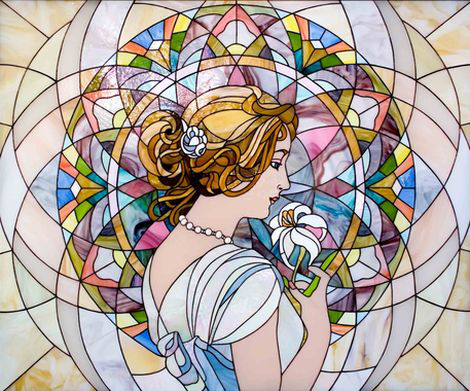

In [5]:
style_image = load(STYLE_IMAGE_PATH)[...,:3] # tf.float32
show([style_image], domain=None, w=256)  

In [0]:
def use_checkpoints_and_tboard():
  """Save checkpoints to google Drive using symbolic link """
  if os.path.isdir('/content/drive'):
    check_if_link = !ls -al /content/checkpoint
    print("saving checkpoint to google drive...")
    if check_if_link[0].find('/content/drive/')<0:
      dest = os.path.dirname(SAVE_MODEL_PATH)
      !mv $dest "{}_0".format($dest)
      !ln -s '/content/drive/My Drive/checkpoints' $dest
  # launch tensorboard
  ROOT = %pwd
  colab_utils.tboard.launch_tensorboard( bin_dir=ROOT, log_dir=LOG_PATH )

if not os.path.isdir(SAVE_MODEL_PATH): os.makedirs(SAVE_MODEL_PATH)
# use_checkpoints_and_tboard()

# Tensorflow implementation


## preflight checks

In [8]:
# TransformerNetwork.trainable_weights
transformerNetwork_VGG = tf_transformer.TransformerNetwork_VGG(style_image, batch_size=BATCH_SIZE)
check = transformerNetwork_VGG.transformer
print(check, check.trainable_weights) 
check.build(input_shape=(None,256,256,3))
check.summary()

<fast_neural_style_pytorch.tensorflow.transformer.TransformerNetwork object at 0x7fe8043c52e8> []
Model: "transformer_network"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_1 (ConvLayer)           multiple                  7808      
_________________________________________________________________
conv_2 (ConvLayer)           multiple                  18496     
_________________________________________________________________
conv_3 (ConvLayer)           multiple                  73856     
_________________________________________________________________
residual_1 (ResidualLayer)   multiple                  295168    
_________________________________________________________________
residual_2 (ResidualLayer)   multiple                  295168    
_________________________________________________________________
residual_3 (ResidualLayer)   multiple                  295168    
_______________

In [9]:
# see: https://github.com/keras-team/keras-applications/blob/master/keras_applications/vgg16.py
vgg = transformerNetwork_VGG.vgg.loss_model
vgg.build(input_shape=(None,256,256,3))
vgg.summary()

Model: "vgg__model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg_layers (Model)           [(None, 16, 16, 512), (No 15304768  
Total params: 15,304,768
Trainable params: 0
Non-trainable params: 15,304,768
_________________________________________________________________


## prepare `TFRecordDataset`

count= 1000 , size= 16667571



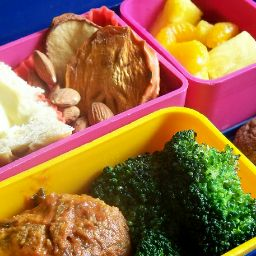
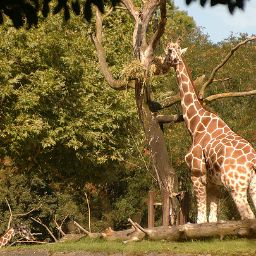
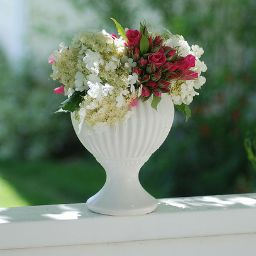

In [10]:
RecordsetHelper = fnstf_utils.ImageRecordDatasetFactory
rec_dataset = tf.data.TFRecordDataset(RECORD_PATH) # /content/coco2014-sq-1000.tfrecord
image_ds_255 = rec_dataset.map(RecordsetHelper.example_parser(image2tensor=True, normalize=True))


count = rec_dataset.reduce(0, lambda x, _: x + 1)
print("count=",count.numpy(), ", size=", os.path.getsize(RECORD_PATH))
check = [d['image'] for d in image_ds_255.take(3)]
show(check, w=128)


In [0]:
# losses: see also, fnstf_utils.get_SUM_mse_loss()
MSELoss = tf.keras.losses.MSE
# works for both style and content losses
def get_MEAN_mse_loss(y_true, y_pred, weights=None):
  if isinstance(y_pred, (tuple, list)):
    if weights is not None:
      assert len(weights)==len(y_pred), "weights do not match"
      losses = [ get_MEAN_mse_loss(y_true, y_pred, w) for (y_true, y_pred, w) in zip(y_true, y_pred, weights) ]
    else:
      losses = [ get_MEAN_mse_loss(y_true, y_pred, None) for (y_true, y_pred) in zip(y_true, y_pred) ]
    return tf.reduce_mean(losses)
  if tf.is_tensor(y_pred):
    batch_size = y_pred.shape[0]
    weights = weights or 1.
    return tf.reduce_mean(MSELoss(y_true[:batch_size], y_pred)) * weights
  assert False, "unexpected input"


## `keras.callbacks`

In [0]:
class SnapshotCallback(tf.keras.callbacks.Callback):
  def __init__(self, validation_images, model=None, stacker=None, epoch_offset=0, log_after_batch=None):
    super(SnapshotCallback, self).__init__()
    self.image = validation_images # image or [image1, image2, ...]
    self.model = model
    self.stacker = stacker if stacker is not None else helpers.ImgStacker()
    self.offset = epoch_offset
    self.batch = 0
    self.batch_count = 0
    self.log_after_batch=log_after_batch

  def getImage(self):
    if isinstance(self.image, (list,tuple)):
      check_image = self.image.pop(0)
      self.image.append(check_image)
    else:
      check_image = self.image
    if len(check_image.shape)==3: check_image = check_image[tf.newaxis,...]
    return check_image

  def show_latest(self):
    show( self.stacker.hstack(), w=128, domain=(0,255))
    return

  def push_latest(self):
    if self.stacker is not None:
      input_batch = self.getImage()
      _transformer = self.model.transformer if hasattr(self.model, 'transformer') else self.model
      generated_image = _transformer(input_batch)
      rgb_image = tf.squeeze(generated_image).numpy() # 255.
      rgb_clipped = rgb_image.clip(0.,255.)
      check = self.stacker.hstack( rgb_clipped, limit=10 )
      show( check, domain=(0,255) )

  def save_latest(self, count):
    if self.stacker is not None:
      # save generated image history
      try:
        sample_image_path = os.path.join(SAVE_IMAGE_PATH , "tf_sample_{}.png".format(count))
        im=Image.fromarray(np.uint8(self.stacker.hstack()))
        im.save(sample_image_path)
      except:
        pass

  def on_batch_end(self, batch, logs=None):
    # on_batch_end: logs include `loss`, and optionally `acc`
    # logs = logs or {}
    first = batch==0
    self.batch = np.maximum(batch, self.batch)
    if self.log_after_batch is not None and batch % self.log_after_batch==0:
      self.push_latest()
      if logs and hasattr(logs,'loss'):
        print('For batch {}, loss is {:7.2f}.'.format(batch, logs['loss']))
      if not first and batch % (self.log_after_batch*10):
        self.save_latest(batch)

  def on_epoch_end(self, epoch, logs=None):
    # on_epoch_end: logs include `acc` and `loss`, and optionally include `val_loss` (if validation is enabled in `fit`), and `val_acc`
    # logs = logs or {}
    # epoch is 0-based
    num_batches = self.batch
    self.batch_count += num_batches
    self.batch = 0 # reset for next epoch

    overall = self.offset*num_batches + self.batch_count
    if self.log_after_batch is None and overall % 1==0:
      self.push_latest() 
      self.save_latest(overall)


In [0]:
class HistoryCallback():
  """ emulate history = model.fit() output 
  usage: 
    history = HistoryCallback()
    losses = history.history()
  """
  _batches = [] 
  _history = [] 
  def on_batch_end(self, batch, losses, logs=None):
    assert len(losses)==6, "expecting 6 loss values, got {}".format(losses)
    self._batches.append(losses)
    return len(self._batches)

  def on_epoch_end(self, epoch, logs=None):
    batch_losses = tf.convert_to_tensor(self._batches) # shape=(NUM_BATCHES,6)
    epoch_losses = tf.reduce_mean(batch_losses, axis=0) # shape=(1,6)
    # ???: epoch_losses /=BATCH_SIZE 
    self._history.append( epoch_losses )
    self._batches=[]
    return epoch_losses

  def history(self, as_dict=False, prefix="loss"):
    losses = tf.convert_to_tensor(self._history) # shape=(NUM_EPOCHS,6)
    if not as_dict: return losses

    # format as dict
    result = {}
    rows, cols = losses.shape
    for c in range(cols):
      key = "{}_{}".format(prefix, c)
      result[key] = losses[:,c]
    return result


# Transformer network with VGG output



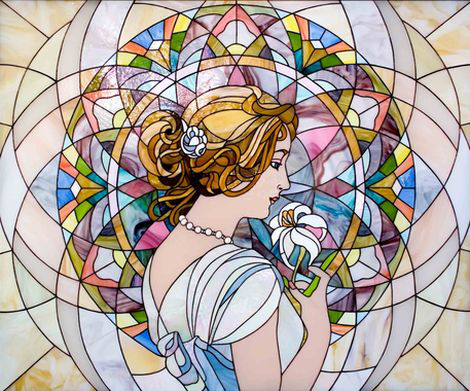

In [14]:
transformerNetwork_VGG = tf_transformer.TransformerNetwork_VGG(style_image, batch_size=BATCH_SIZE)
get_MEAN_mse_loss = fnstf_utils.get_MEAN_mse_loss
transformerNetwork_VGG.vgg.style_image = style_image
show([style_image], labels=["style_image, shape={}".format(style_image.shape)], w=128, domain=(0.,255.) )

In [0]:
# class VGG_Features():
#   def __init__(self, loss_model, style_image=None, target_style_gram=None):
#     self.loss_model = loss_model
#     if style_image is not None:
#       assert style_image.shape == (256,256,3), "ERROR: loss_model expecting input_shape=(256,256,3), got {}".format(style_image.shape)
#       self.style_image = style_image
#       self.target_style_gram = VGG_Features.get_style_gram(self.loss_model, self.style_image)
#     if target_style_gram is not None:
#       self.target_style_gram = target_style_gram

#   @staticmethod
#   def get_style_gram(vgg_features_model, style_image):
#     style_batch = tf.repeat( style_image[tf.newaxis,...], repeats=BATCH_SIZE, axis=0)
#     # show([style_image], w=128, domain=(0.,255.) )

#     # B, H, W, C = style_batch.shape
#     (_, style_features) = vgg_features_model( style_batch , preprocess=True ) # hwcRGB
#     target_style_gram = [ fnstf_utils.gram(value)  for value in style_features ]  # list
#     return target_style_gram  

#   def __call__(self, input_batch):
#     content_features, style_features = self.loss_model( input_batch, preprocess=True )
#     style_gram = [ fnstf_utils.gram(value)  for value in style_features ]  # list
#     # return (content_features[0], tuple(style_gram) )            # tuple of (tensor, tuple ) [OK], still counts as 6 outputs!!!
        
#     # # name tensors for loss reporting
#     content_f = tf.identity(content_features[0], name="content_0")
#     style_f = [tf.identity(f, name="style_{}".format(i)) for i, f in enumerate(style_gram)]

#     # return as FLAT tuple 
#     return tuple([content_f] + style_f )            # tuple of (tensor,... ) [OK], 6 outputs




In [0]:

# class TransformerNetwork_VGG(tf.keras.Model):
#   def __init__(self, style_image):
#     super(TransformerNetwork_VGG, self).__init__()

#     TransformerNetwork = tf_transformer.TransformerNetwork()
#     TransformerNetwork.trainable = True
#     style_model = tf_vgg.get_layers("vgg19")
#     VGG = tf_vgg.vgg_layers19( style_model['content_layers'], style_model['style_layers'] )

#     if tf.is_tensor(style_image) and style_image.shape==(256,256,3):
#       vGGfeatures = VGG_Features(VGG, style_image=style_image)
#     else: 
#       target_style_gram = TransformerNetwork_VGG2._get_target_style_gram_from_image(style_image, style_model)
#       vGGfeatures = VGG_Features(VGG, target_style_gram=target_style_gram)
    
#     self.transformer = TransformerNetwork
#     self.vgg = vGGfeatures

#   def call(self, inputs):
#     x = inputs
#     x = self.transformer(x)
#     x = self.vgg(x)
#     return x

#   @staticmethod
#   def _get_target_style_gram_from_image(style_image, style_model):
#     """"use when style_image.shape != (256,256,3)"""
#     VGG_Target = tf_vgg.vgg_layers19( style_model['content_layers'], style_model['style_layers'], input_shape=None )
#     if isinstance(style_image,str):
#       image_string = tf.io.read_file(style_image)
#       style_image = fnstf_utils.ImageRecordDatasetFactory.image2tensor(image_string, normalize=False)
#       # if len(style_image.shape)==3: style_image = style_image[tf.newaxis,...]
#     target_style_gram = VGG_Features.get_style_gram(VGG_Target, style_image)
#     show([style_image], labels=["style_image, shape={}".format(style_image.shape)], w=128, domain=(0.,255.) )
#     return target_style_gram

# transformerNetwork_VGG = TransformerNetwork_VGG(style_image)

In [16]:
# # get y_true from generator
tensor_ds_255 = image_ds_255.map(lambda d: d['image'])


def BATCH_xyGenerator_y_true_as_features_and_weights(tensor_ds_255, 
                                                     VGGfeatures,
                                                     feature_weights=None
                                                     ):
  """ returns generator with weights(x_train, y_true, weights)
  """

  if feature_weights is not None: print("dataset generator using FEATURE_WEIGHTS=", feature_weights)
  
  def gen():
    weights = tuple( [v] for v in feature_weights) if feature_weights else tuple( [1.] for v in range(6))
    for x_train in tensor_ds_255.batch(BATCH_SIZE):
      batch = x_train if len(x_train.shape)==4 else x_train[tf.newaxis,...]

      # # # return as tuple( tensor, tuple) or tuple( tensor, ...)
      y_true_features = VGGfeatures(batch)
      if isinstance(y_true_features, (tuple, list)):
        if len(y_true_features)==2:
          # must FLATTEN to tuple( tensor, ...)
          content, style = y_true_features
          y_true_features = tuple([content] + list(style))
        else:
          pass # FLAT tuple(tensor x6) OK

      elif isinstance(y_true_features, dict): 
        # return as dict, see VGGfeatures.__call__()
        # y_true_features = VGGfeatures(batch)
        pass

      yield (x_train, y_true_features, weights)

  output_types= (
      tf.float32,    
      ( 
        tf.float32,       tf.float32, tf.float32, tf.float32, tf.float32, tf.float32
      ),
      (tf.float32,       tf.float32, tf.float32, tf.float32, tf.float32, tf.float32)
  )

  output_shapes = ( 
      (None, 256,256,3),
      (
        (None, 16, 16, 512),
        (None, 64, 64), (None, 128, 128), (None, 256, 256), (None, 512, 512), (None, 512, 512)
      ),
      (
          (1,),     (1,),(1,),(1,),(1,),(1,)
      )
  )
  return tf.data.Dataset.from_generator(
                                      generator=gen, 
                                      output_types=output_types, 
                                      output_shapes=output_shapes,
                                    )

reduce_sum_FEATURE_WEIGHTS = [31.51, 823.95 , 33.20, 44.95, 1.1, 1889.85 ]
reduce_mean_FEATURE_WEIGHTS = [34.34, 872.6, 32.4, 44.65, 1.1, 2099.35]
ONES = [1.,1.,1.,1.,1.,1.,]
FEATURE_WEIGHTS = ONES

BATCH_xy_Dataset255_with_features = BATCH_xyGenerator_y_true_as_features_and_weights(
    tensor_ds_255, 
    transformerNetwork_VGG.vgg,
    feature_weights=FEATURE_WEIGHTS)



dataset generator using FEATURE_WEIGHTS= [1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


### standard training, `model.fit()` 

In [17]:
use_checkpoints_and_tboard()

ngrok installed
status: tensorboard=False, ngrok=True
tensorboard url= https://b5f7fb10.ngrok.io



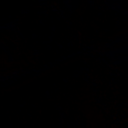

dataset generator using FEATURE_WEIGHTS= [1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Train for 2 steps
Epoch 1/2
1/2 [==============>...............] - ETA: 31s - loss: 36650.1250 - output_1_loss: 76.0615 - output_2_loss: 3.8613 - output_3_loss: 106.0857 - output_4_loss: 129.7302 - output_5_loss: 36333.2344 - output_6_loss: 1.1520


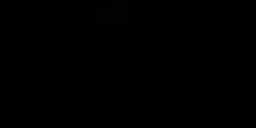

2/2 [==============================] - 58s 29s/step - loss: 22085.2661 - output_1_loss: 54.8163 - output_2_loss: 2.2541 - output_3_loss: 62.4942 - output_4_loss: 80.6277 - output_5_loss: 21884.3516 - output_6_loss: 0.7212
Epoch 2/2
1/2 [==============>...............] - ETA: 22s - loss: 820.4246 - output_1_loss: 4.6900 - output_2_loss: 0.4419 - output_3_loss: 6.8292 - output_4_loss: 4.5674 - output_5_loss: 803.8721 - output_6_loss: 0.0241


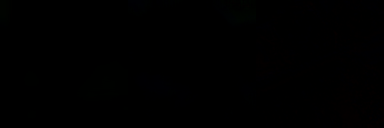

2/2 [==============================] - 46s 23s/step - loss: 539.4906 - output_1_loss: 2.7141 - output_2_loss: 0.3245 - output_3_loss: 4.5387 - output_4_loss: 3.0854 - output_5_loss: 528.8126 - output_6_loss: 0.0154



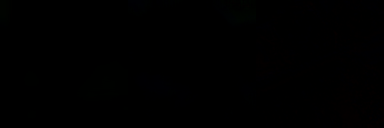

In [18]:
np.random.seed(SEED)
tf.random.set_seed(SEED)

TransformerNetwork_VGG = tf_transformer.TransformerNetwork_VGG(style_image, batch_size=BATCH_SIZE)
TransformerNetwork_VGG.trainable = True
TransformerNetwork_VGG.transformer.trainable = True
TransformerNetwork_VGG.vgg.trainable = False


# # Optimizer settings
optimizer = tf.optimizers.Adam(learning_rate=ADAM_LR, beta_1=0.99, epsilon=1e-1)


# helpers for monitoring training
stacker = helpers.ImgStacker()
stacker.clear()
validation_imgs = [ image for image in tensor_ds_255.take(10)]
Snapshot = SnapshotCallback(validation_imgs, model=TransformerNetwork_VGG, stacker=stacker, log_after_batch=None)


NUM_EPOCHS = 5
NUM_BATCHES = 250 # =1000/BATCH_SIZE

ONES =                          [1.,1.,1.,1.,1.,1.,]
normalized_weights =            [   18.54,           1605.23,   25.08,    8.16,    1.28, 2330.79]
boost_style_FEATURE_WEIGHTS =   [   0.1854,          1605.23,   25.08,    8.16,    1.28, 2330.79]  # boost style loss x100
FEATURE_WEIGHTS = ONES

TransformerNetwork_VGG.compile(
  optimizer=optimizer,
  loss=get_MEAN_mse_loss,
)
checkpoint_prefix = os.path.join(SAVE_MODEL_PATH, "std-training_checkpoint_{epoch}.h5")
callbacks = [
  Snapshot,
  # tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_prefix, 
  #                                   save_freq="epoch",
  #                                   save_weights_only=True
  #                                   ),
  # tf.keras.callbacks.TensorBoard(log_dir=LOG_PATH),
]

Snapshot.push_latest()

BATCH_xy_Dataset255_with_features = BATCH_xyGenerator_y_true_as_features_and_weights(
      tensor_ds_255, 
      TransformerNetwork_VGG.vgg,
      feature_weights=FEATURE_WEIGHTS
    )
train_dataset = BATCH_xy_Dataset255_with_features.take(BATCH_SIZE * NUM_BATCHES)

history = TransformerNetwork_VGG.fit(
  x=train_dataset.repeat(NUM_EPOCHS),
  epochs=NUM_EPOCHS,
  steps_per_epoch=NUM_BATCHES,
  callbacks=callbacks,
)

Snapshot.show_latest()


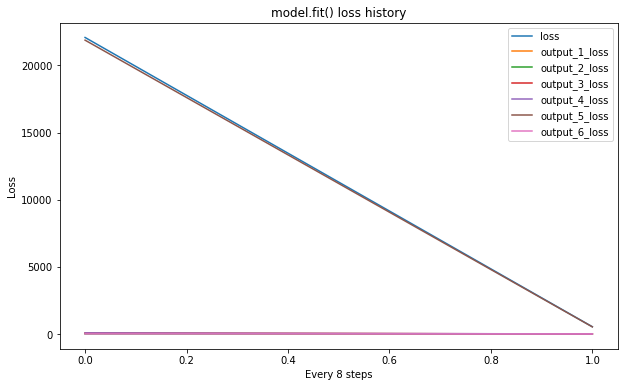


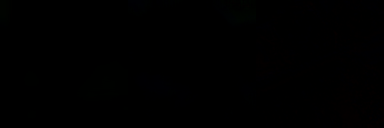

In [19]:
# plot losses
import matplotlib.pyplot as plt
# print (history.history)
plt.figure(figsize=[10, 6])
for i,(k,v) in enumerate(history.history.items()):
  x = [i for i in range(len(v))]
  plt.plot(x, v, label=k)

plt.legend()
plt.xlabel('Every {} steps'.format(BATCH_SIZE * NUM_BATCHES))
plt.ylabel('Loss')
plt.title("model.fit() loss history")
plt.show()

Snapshot.show_latest()

In [20]:
# get_loss_weights_from_history = fnstf_utils.get_normalized_weights_from_loss_history
def get_loss_weights_from_history(history, step=-1):
  """ get normalized loss weights from a training run with no loss weights
    history = model.fit() with no loss weights
  """
  if hasattr(history, 'history'): history = history.history
  assert isinstance(history, dict), "ERROR: expecting history.history as dict of losses"

  losses = np.asarray([v for k,v in history.items()])
  step_losses = losses[:,-1]
  print("step={}, losses={}".format(losses.shape[1],  step_losses))
  total_loss = np.sum(step_losses)
  loss_weights = total_loss/step_losses
  np.set_printoptions(precision=2, suppress=True) # don't use scientific notation
  print("normalized weights:", loss_weights)
  return loss_weights


FEATURE_WEIGHTS = get_loss_weights_from_history(history)


step=2, losses=[5.395e+02 2.714e+00 3.245e-01 4.539e+00 3.085e+00 5.288e+02 1.536e-02]
normalized weights: [    2.     397.55  3324.77   237.73   349.71     2.04 70223.39]


# `tf.GradientTape` 


### tf.GradientTape with `TransformerNetwork_VGG()`

In [0]:
# use_checkpoints_and_tboard()

dataset generator using FEATURE_WEIGHTS= [1.0, 1.0, 1.0, 1.0, 1.0, 1.0]



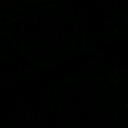

========Epoch 1/2========
========Iteration 1/4========
	Content Loss:	92.83
	Style Loss:	38358.85
	Total Loss:	38451.68
Time elapsed:	29.819642305374146 seconds
========Iteration 4/4========
	Content Loss:	57.33
	Style Loss:	16460.98
	Total Loss:	16518.32
Time elapsed:	107.94178080558777 seconds
>>>> epoch=1 complete
>>>> 	epoch=1: losses= [   50.035     1.575    79.61    196.762 10929.78      0.761]



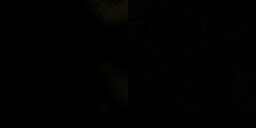

========Epoch 2/2========
>>>> epoch=2 complete
>>>> 	epoch=2: losses= [  64.054    1.306   38.735  173.335 4942.512    0.743]



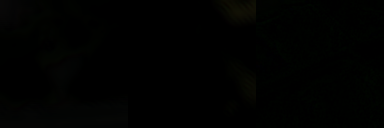

Done Training the Transformer Network!
Training Time: 419.92924523353577 seconds
========Content Loss========
[92.829315, 57.334778]
========Style Loss========
[38358.848, 16460.98]
========Total Loss========
[38451.676, 16518.316]


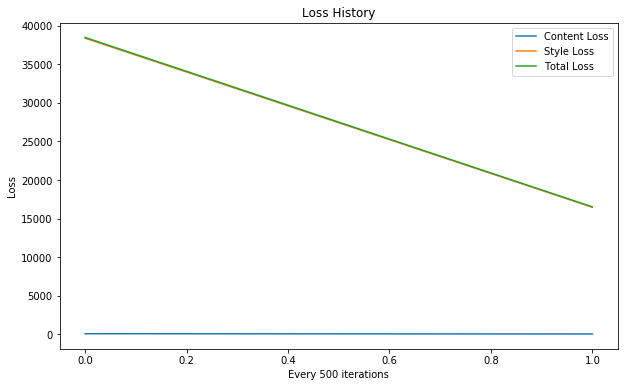

In [22]:
### tf.GradientTape:

np.random.seed(SEED)
tf.random.set_seed(SEED)

### configure for TransformerNetwork_VGG 
TransformerNetwork_VGG = tf_transformer.TransformerNetwork_VGG(style_image, batch_size=BATCH_SIZE)

TransformerNetwork = TransformerNetwork_VGG.transformer
VGG = TransformerNetwork_VGG.vgg

ONES =                          [1.,1.,1.,1.,1.,1.,]
normalized_weights =            [   18.54,           1605.23,   25.08,    8.16,    1.28, 2330.79]
boost_style_FEATURE_WEIGHTS =   [   0.1854,          1605.23,   25.08,    8.16,    1.28, 2330.79]  # boost style loss x100
FEATURE_WEIGHTS = ONES

BATCH_xy_Dataset255_with_features = BATCH_xyGenerator_y_true_as_features_and_weights(
      tensor_ds_255, 
      TransformerNetwork_VGG.vgg,
      feature_weights=FEATURE_WEIGHTS
    )
train_dataset = BATCH_xy_Dataset255_with_features.take(BATCH_SIZE * NUM_BATCHES)
NUM_EPOCHS = 5
NUM_BATCHES = 250 # =1000/BATCH_SIZE

# pre-flight
stacker = helpers.ImgStacker()
stacker.clear()
validation_imgs = [ image for image in tensor_ds_255.take(10)]
Snapshot = SnapshotCallback(validation_imgs, TransformerNetwork_VGG.transformer, stacker=stacker, log_after_batch=None)
  
history = HistoryCallback()

def train():
  # # Seeds
  np.random.seed(SEED)
  tf.random.set_seed(SEED)

  # # Optimizer settings
  optimizer = tf.optimizers.Adam(learning_rate=ADAM_LR, beta_1=0.99, epsilon=1e-1)

  # # Loss trackers
  content_loss_history = []
  style_loss_history = []
  total_loss_history = []
  batch_content_loss_sum = 0.
  batch_style_loss_sum = 0.
  batch_total_loss_sum = 0.

  # # Optimization/Training Loop
  @tf.function()
  def train_step(x_train, y_true, loss_weights=None, log_freq=10):
    with tf.GradientTape() as tape:
      y_pred = TransformerNetwork_VGG(x_train)
      generated_content_features = y_pred[:1]
      generated_style_gram = y_pred[1:]
      

      y_true = TransformerNetwork_VGG.vgg(x_train)
      target_content_features = y_true[:1]
      target_style_gram = TransformerNetwork_VGG.vgg.target_style_gram

      if loss_weights:
        assert len(loss_weights) == len(y_pred), "ERROR: invalid format for loss_weights, got {}".format(loss_weights)

      # loss_function = get_SUM_mse_loss   
      loss_function = get_MEAN_mse_loss   
      weights = loss_weights[:1] if loss_weights else None
      content_loss = loss_function(target_content_features, generated_content_features, weights)

      weights = loss_weights[1:] if loss_weights else None
      # style_loss = loss_function(target_style_gram, generated_style_gram, weights)
      style_loss = tuple(loss_function(x,y)*w for x,y,w in zip(target_style_gram, generated_style_gram, weights))
      total_style_loss = tf.reduce_sum(style_loss)

      # apply batch_losses to grads
      total_loss = content_loss + total_style_loss
      TransformerNetwork = TransformerNetwork_VGG.transformer
      grads = tape.gradient(total_loss, TransformerNetwork.trainable_weights)
      optimizer.apply_gradients(zip(grads, TransformerNetwork.trainable_weights))
      return (content_loss, total_style_loss, style_loss)
      # end: with tf.GradientTape()
      # end: train_step()


  batch_count = 1
  Snapshot.push_latest()
  start_time = time.time()
  for epoch in range(NUM_EPOCHS):
    print("========Epoch {}/{}========".format(epoch+1, NUM_EPOCHS))
    for x_train, y_true, weights in train_dataset:
      # x_train, y_true are VGG features
      # print("{}: batch shape={}".format(batch_count, x_train.shape))
      # Get current batch size in case of odd batch sizes
      curr_batch_size = x_train.shape[0]

      #   # Backprop and Weight Update
      (content_loss, style_loss, s_loss) = train_step(x_train, y_true, loss_weights=FEATURE_WEIGHTS ) # 255.
      batch_content_loss_sum += content_loss
      batch_style_loss_sum += style_loss
      batch_total_loss_sum += (content_loss + style_loss)

      batch_no = history.on_batch_end( batch_count-1, (content_loss,) + s_loss ) # loss= list of tuples    
      Snapshot.on_batch_end(batch_no)

      # Save Model and Print Losses
      if (((batch_count-1)% SAVE_MODEL_EVERY == 0) or (batch_count==NUM_EPOCHS*NUM_BATCHES)):
        # generated_batch = TransformerNetwork_VGG.transformer(x_train)
        # rgb_image = generated_batch[0]
        # check = stacker.hstack( tf.clip_by_value(rgb_image, 0.,255.), limit=NUM_EPOCHS, smaller=True )
        # show( check, domain=None )
        # check side by side
        # [rgb_image0, rgb_image] = [tf.squeeze(tf.clip_by_value(v[0], 0., 255.)) for v in [x_train, generated_batch]]
        # show([rgb_image0, rgb_image], domain=(0.,255.), w=128)

        # Print Losses
        print("========Iteration {}/{}========".format(batch_count, NUM_EPOCHS*NUM_BATCHES))
        print("\tContent Loss:\t{:.2f}".format(batch_content_loss_sum/batch_count))
        print("\tStyle Loss:\t{:.2f}".format(batch_style_loss_sum/batch_count))
        print("\tTotal Loss:\t{:.2f}".format(batch_total_loss_sum/batch_count))
        print("Time elapsed:\t{} seconds".format(time.time()-start_time))

        # rgb_image = tf.squeeze(generated_batch[0,...]).numpy() # 255.
        # check = np.stack([np.amin(rgb_image, axis=(0,1)), np.average(rgb_image, axis=(0,1)), np.amax(rgb_image, axis=(0,1))], axis=1)
        # print( "\tImage, (min,mean,max):\t{}".format( check ) )

        # # rgb_batch = tf.image.convert_image_dtype(generated_batch/255., dtype=tf.uint8, saturate=True)
        # generated_batch = tf.clip_by_value(generated_batch, 0.,255.)
        # show(generated_batch, w=128, domain=(0,255))

        # Save loss histories
        content_loss_history.append((batch_content_loss_sum/batch_count).numpy())
        style_loss_history.append((batch_style_loss_sum/batch_count).numpy())
        total_loss_history.append((batch_total_loss_sum/batch_count).numpy())


      # Iterate Batch Counter
      batch_count+=1

    # end epoch, summarize batch_losses
    print(">>>> epoch={} complete".format(epoch+1))
    epoch_loss = history.on_epoch_end( epoch+1 ) # close batch, return sum of batch_losses, shape=(1,6)
    print(">>>> \tepoch={}: losses= {}".format(epoch+1, epoch_loss.numpy()))
    Snapshot.on_epoch_end(epoch)

    # # Save Model
    # if batch_count>1:
    #   checkpoint_path = os.path.join(SAVE_MODEL_PATH, "grad-tape_checkpoint_{}.h5".format(epoch+1))
    #   TransformerNetwork_VGG.transformer.save_weights(checkpoint_path, save_format='h5')
    #   print("Saved tf TransformerNetwork checkpoint file at {}".format(checkpoint_path))

    # # Save generated image
    # sample_image_path = os.path.join(SAVE_IMAGE_PATH, "tf_sample_{}.png".format(epoch+1))
    # im=Image.fromarray(np.uint8(stacker.hstack()))
    # im.save(sample_image_path)
    # print("Saved sample tranformed image at {}".format(sample_image_path))

  stop_time = time.time()

  # Print loss histories
  print("Done Training the Transformer Network!")
  print("Training Time: {} seconds".format(stop_time-start_time))
  print("========Content Loss========")
  print(content_loss_history) 
  print("========Style Loss========")
  print(style_loss_history) 
  print("========Total Loss========")
  print(total_loss_history) 
  # Plot Loss Histories
  if (PLOT_LOSS):
      torch_utils.plot_loss_hist(content_loss_history, style_loss_history, total_loss_history)

  # save generated image history
  sample_image_path = os.path.join(SAVE_IMAGE_PATH , "tf_sample_{}.png".format(NUM_EPOCHS*NUM_BATCHES))
  im=Image.fromarray(np.uint8(stacker.hstack()))
  im.save(sample_image_path)

train()


step=2, losses=[  64.054    1.306   38.735  173.335 4942.512    0.743]
normalized weights: [  81.5  3997.12  134.78   30.12    1.06 7023.38]


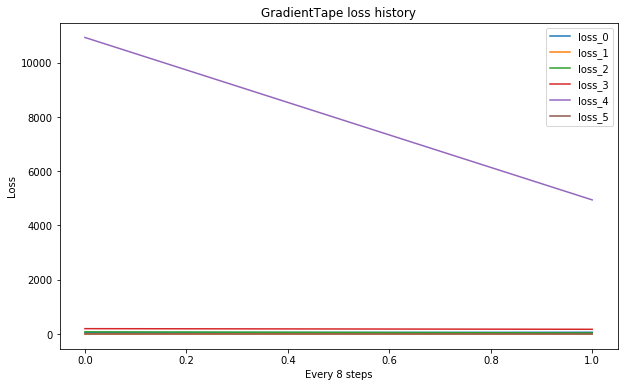


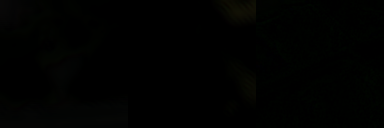

In [23]:
history_losses = history.history(as_dict=True) # shape=(NUM_EPOCHS, 6)
get_loss_weights_from_history(history_losses)

# plot losses
plt.figure(figsize=[10, 6])
for i,(k,v) in enumerate(history_losses.items()):
  x = [i for i in range(len(v))]
  plt.plot(x, v, label=k)

plt.legend()
plt.xlabel('Every {} steps'.format(BATCH_SIZE * NUM_BATCHES))
plt.ylabel('Loss')
plt.title("GradientTape loss history")
plt.show()

Snapshot.show_latest()

In [24]:
assert False

style_model = tf_vgg.get_layers()

def vgg_layers19(content_layers, style_layers, input_shape=(256,256,3)):
  """ creates a VGG model that returns output values for the given layers
  see: https://keras.io/applications/#extract-features-from-an-arbitrary-intermediate-layer-with-vgg19

  Returns: 
    function(x, preprocess=True):
      Args: 
        x: image tuple/ndarray h,w,c(RGB), domain=(0.,255.)
      Returns:
        a tuple of lists, ([content_features], [style_features])

  usage:
    (content_features, style_features) = vgg_layers16(content_layers, style_layers)(x_train)
  """
  from tensorflow.keras.applications.vgg19 import preprocess_input
  base_model = tf.keras.applications.VGG19(include_top=False, weights='imagenet', input_shape=input_shape)
  return VGG_Model(content_layers, style_layers, base_model, preprocessingFn=preprocess_input)

class VGG_Model(tf.keras.models.Model):
  def __init__(self, content_layers, style_layers, base_model, preprocessingFn=None, **kwargs):
    super(VGG_Model, self).__init__(**kwargs)
    self.layer_names = content_layers + style_layers
    self.content_layer_split = len(content_layers)
    self.preprocessingFn = preprocessingFn
    base_model.trainable = False
    content_features = [base_model.get_layer(name).output for name in content_layers]
    style_features = [base_model.get_layer(name).output for name in style_layers]
    output_features = content_features + style_features
    self.model = tf.keras.models.Model( inputs=base_model.input, outputs=output_features, name="vgg_layers")
    self.model.trainable = False

  def call(self, x, preprocess=True):
    if preprocess and callable(self.preprocessingFn): 
      x = self.preprocessingFn(x)
    output = self.model(x) # call as tf.keras.Layer()
    return ( output[:self.content_layer_split], output[self.content_layer_split:] )

vgg = vgg_layers19(style_model['content_layers'], style_model['style_layers'] )
vgg.build(input_shape=(None,256,256,3))
vgg.summary()

AssertionError: ignored